In [ ]:
!pip install deap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.6 MB/s eta 0:00:00


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from deap import base, creator, tools, algorithms


In [ ]:
# ------------------------------------------------------------------
# Configuração DEAP: Classes de fitness e indivíduo (lista binária)
# ------------------------------------------------------------------
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)


In [ ]:
# ------------------------------------------------------------------
# Função para gerar uma lista de itens (peso, valor)
# ------------------------------------------------------------------
def generate_items(n, weight_range=(1, 10), value_range=(1, 20)):
    items = []
    for _ in range(n):
        weight = random.randint(*weight_range)
        value = random.randint(*value_range)
        items.append((weight, value))
    return items
ITEMS = None
CAPACITY = None

In [ ]:
# ------------------------------------------------------------------
# Função de avaliação do problema da mochila
# ------------------------------------------------------------------
def evalKnapsack(individual):
    total_weight = sum(individual[i] * ITEMS[i][0] for i in range(len(ITEMS)))
    total_value  = sum(individual[i] * ITEMS[i][1] for i in range(len(ITEMS)))
    if total_weight > CAPACITY:
        return 0,  # Penaliza soluções inviáveis
    return total_value,

# ------------------------------------------------------------------
# Criação do toolbox para uma instância específica (itens e capacidade)
# ------------------------------------------------------------------
def create_toolbox(items, capacity):
    global ITEMS, CAPACITY
    ITEMS = items
    CAPACITY = capacity
    tb = base.Toolbox()
    tb.register("attr_bool", random.randint, 0, 1)
    tb.register("individual", tools.initRepeat, creator.Individual, tb.attr_bool, n=len(items))
    tb.register("population", tools.initRepeat, list, tb.individual)
    tb.register("evaluate", evalKnapsack)
    tb.register("mate", tools.cxTwoPoint)
    tb.register("mutate", tools.mutFlipBit, indpb=0.05)
    tb.register("select", tools.selTournament, tournsize=3)
    return tb

# ------------------------------------------------------------------
# Busca Local (Hill Climbing) – utilizada no Memetic GA
# ------------------------------------------------------------------
def local_search(individual, tb, max_iter=10):
    current = individual[:]
    current_fitness = tb.evaluate(current)[0]
    iterations = 0
    improved = True
    while improved and iterations < max_iter:
        improved = False
        for i in range(len(current)):
            neighbor = current[:]
            neighbor[i] = 1 - neighbor[i]  # inverte o bit
            neighbor_fitness = tb.evaluate(neighbor)[0]
            if neighbor_fitness > current_fitness:
                current = neighbor
                current_fitness = neighbor_fitness
                improved = True
                break  # reinicia a busca a partir do novo indivíduo
        iterations += 1
    return current

# ------------------------------------------------------------------
# Função de evolução – suporta três estratégias evolutivas:
# "GA" (padrão), "Memetic" (com busca local) e "Adaptive" (taxa de mutação adaptativa)
# ------------------------------------------------------------------
def run_evolution(tb, algorithm_type="GA", cxpb=0.5, init_mutpb=0.2,
                  population_size=300, ngen=100, seed=64):
    random.seed(seed)
    pop = tb.population(n=population_size)
    best_fitness_curve = []
    current_mutpb = init_mutpb
    prev_best = None

    for gen in range(ngen):

        offspring = algorithms.varAnd(pop, tb, cxpb=cxpb, mutpb=current_mutpb)

        if algorithm_type == "Memetic":

            offspring = [creator.Individual(local_search(ind, tb)) for ind in offspring]

        for ind in offspring:
            ind.fitness.values = tb.evaluate(ind)

        pop = tb.select(offspring, k=len(pop))
        gen_best = max(ind.fitness.values[0] for ind in pop)
        best_fitness_curve.append(gen_best)

        if algorithm_type == "Adaptive":

            if prev_best is not None:
                if gen_best <= prev_best:
                    current_mutpb = min(current_mutpb * 1.2, 0.5)
                else:
                    current_mutpb = max(current_mutpb * 0.8, 0.05)
            prev_best = gen_best

    best_ind = tools.selBest(pop, 1)[0]
    return best_fitness_curve, best_ind

# ------------------------------------------------------------------
# Algoritmo Ganancioso (Greedy): seleciona itens com base na razão valor/peso
# ------------------------------------------------------------------
def greedy_knapsack(items, capacity):
    sorted_items = sorted(enumerate(items), key=lambda x: x[1][1] / x[1][0], reverse=True)
    solution = [0] * len(items)
    total_weight = 0
    total_value = 0
    for idx, (w, v) in sorted_items:
        if total_weight + w <= capacity:
            solution[idx] = 1
            total_weight += w
            total_value += v
    return solution, total_value, total_weight

# ------------------------------------------------------------------
# Executa múltiplas runs para uma instância específica, retornando
# média, desvio e melhor valor final para um método evolutivo.
# ------------------------------------------------------------------
def run_instance_experiment(algorithm_type, items, capacity, num_runs=10,
                            population_size=300, ngen=100, cxpb=0.5, init_mutpb=0.2):
    best_fitnesses = []
    for i in range(num_runs):
        seed = 64 + i
        tb = create_toolbox(items, capacity)
        fitness_curve, best_ind = run_evolution(tb, algorithm_type=algorithm_type,
                                                cxpb=cxpb, init_mutpb=init_mutpb,
                                                population_size=population_size, ngen=ngen, seed=seed)
        best_fitnesses.append(fitness_curve[-1])
    mean_val = np.mean(best_fitnesses)
    std_val = np.std(best_fitnesses)
    best_overall = np.max(best_fitnesses)
    return mean_val, std_val, best_overall

# ------------------------------------------------------------------
# Função que gera as instâncias e executa o experimento para cada combinação
# de tamanho de instância e fator de capacidade, testando todos os métodos.
# ------------------------------------------------------------------
def run_experiments():
    # Instâncias: pequeno (10 itens), médio (50 itens) e grande (100 itens)
    instance_types = {"Small": 10, "Medium": 50, "Large": 100}
    # Três níveis de capacidade: 30%, 50% e 70% do peso total dos itens
    capacity_factors = [0.3, 0.5, 0.7]
    num_runs = 10
    results = {}  # Estrutura: results[instância][fator de capacidade][método] = (mean, std, best) ou valor para Greedy

    for inst_label, n_items in instance_types.items():
        results[inst_label] = {}
        # Gera os itens para a instância
        items = generate_items(n_items, weight_range=(1, 10), value_range=(1, 20))
        total_weight = sum(item[0] for item in items)
        for factor in capacity_factors:
            capacity = int(factor * total_weight)
            results[inst_label][factor] = {}
            for method in ["GA", "Memetic", "Adaptive"]:
                mean_val, std_val, best_overall = run_instance_experiment(method, items, capacity, num_runs=num_runs)
                results[inst_label][factor][method] = (mean_val, std_val, best_overall)
            # Greedy é determinístico
            _, greedy_val, _ = greedy_knapsack(items, capacity)
            results[inst_label][factor]["Greedy"] = greedy_val
            print(f"Instância: {inst_label}, Fator de Capacidade: {factor}, Peso Total: {total_weight}, Capacidade: {capacity}")
            print(f"  GA: Média = {results[inst_label][factor]['GA'][0]:.2f}, Desvio = {results[inst_label][factor]['GA'][1]:.2f}, Melhor = {results[inst_label][factor]['GA'][2]:.2f}")
            print(f"  Memetic: Média = {results[inst_label][factor]['Memetic'][0]:.2f}, Desvio = {results[inst_label][factor]['Memetic'][1]:.2f}, Melhor = {results[inst_label][factor]['Memetic'][2]:.2f}")
            print(f"  Adaptive: Média = {results[inst_label][factor]['Adaptive'][0]:.2f}, Desvio = {results[inst_label][factor]['Adaptive'][1]:.2f}, Melhor = {results[inst_label][factor]['Adaptive'][2]:.2f}")
            print(f"  Greedy: Valor = {results[inst_label][factor]['Greedy']}\n")
    return results, capacity_factors

def plot_results(results, capacity_factors):
    instance_types = list(results.keys())
    fig, axes = plt.subplots(1, len(instance_types), figsize=(18, 5), sharey=True)

    if len(instance_types) == 1:
        axes = [axes]

    for ax, inst in zip(axes, instance_types):
        ga_bests, mem_bests, adapt_bests, greedy_vals = [], [], [], []
        for factor in capacity_factors:
            _, _, ga_best = results[inst][factor]["GA"]
            _, _, mem_best = results[inst][factor]["Memetic"]
            _, _, adapt_best = results[inst][factor]["Adaptive"]
            greedy_val = results[inst][factor]["Greedy"]
            ga_bests.append(ga_best)
            mem_bests.append(mem_best)
            adapt_bests.append(adapt_best)
            greedy_vals.append(greedy_val)

        ax.plot(capacity_factors, ga_bests, '-o', label='GA Padrão')
        ax.plot(capacity_factors, mem_bests, '-s', label='Memetic GA')
        ax.plot(capacity_factors, adapt_bests, '-^', label='GA Adaptativo')
        ax.plot(capacity_factors, greedy_vals, 'd--', label='Greedy')

        ax.set_title(f"Instância {inst} (n={'10' if inst=='Small' else '50' if inst=='Medium' else '100'})")
        ax.set_xlabel("Fator de Capacidade")
        ax.set_xticks(capacity_factors)

        # Removendo espaços extras e grades
        ax.set_frame_on(False)
        ax.margins(0)  # Remove espaços em branco ao redor dos pontos
        ax.set_yticks([])  # Remove marcações do eixo Y para um visual mais limpo
        ax.set_xticks([])  # Remove marcações do eixo X para manter tudo junto

    axes[0].set_ylabel("Melhor Valor Encontrado (Fitness)")
    fig.suptitle("Comparação: Melhor Valor Encontrado\n(GA Padrão vs Memetic GA vs GA Adaptativo vs Greedy)", fontsize=16)

    # Ajuste final para eliminar espaços em branco desnecessários
    plt.tight_layout(pad=0)
    plt.show()

def plot_grouped_bar_charts(results, capacity_factors):
    instance_types = list(results.keys())
    num_instances = len(instance_types)
    bar_width = 0.2  # Largura de cada barra

    for inst_idx, inst in enumerate(instance_types):
        fig, ax = plt.subplots(figsize=(8, 6))

        # Posições das barras no eixo x
        x_pos = np.arange(len(capacity_factors))

        # Dados para cada algoritmo
        ga_bests = [results[inst][factor]["GA"][2] for factor in capacity_factors]
        mem_bests = [results[inst][factor]["Memetic"][2] for factor in capacity_factors]
        adapt_bests = [results[inst][factor]["Adaptive"][2] for factor in capacity_factors]
        greedy_vals = [results[inst][factor]["Greedy"] for factor in capacity_factors]

        # Criar as barras
        ax.bar(x_pos - 1.5*bar_width, ga_bests, bar_width, label='GA Padrão')
        ax.bar(x_pos - 0.5*bar_width, mem_bests, bar_width, label='Memetic GA')
        ax.bar(x_pos + 0.5*bar_width, adapt_bests, bar_width, label='GA Adaptativo')
        ax.bar(x_pos + 1.5*bar_width, greedy_vals, bar_width, label='Greedy')

        # Configurar o gráfico
        ax.set_title(f"Comparação de Algoritmos - Instância {inst}")
        ax.set_xlabel("Fator de Capacidade")
        ax.set_ylabel("Melhor Valor Encontrado (Fitness)")
        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(factor) for factor in capacity_factors])
        ax.legend()

        plt.tight_layout()
        plt.show()


In [ ]:
# ------------------------------------------------------------------
# Função Principal
# ------------------------------------------------------------------

results, capacity_factors = run_experiments()
#plot_results(results, capacity_factors)



Instância: Small, Fator de Capacidade: 0.3, Peso Total: 57, Capacidade: 17
  GA: Média = 55.00, Desvio = 0.00, Melhor = 55.00
  Memetic: Média = 55.00, Desvio = 0.00, Melhor = 55.00
  Adaptive: Média = 55.00, Desvio = 0.00, Melhor = 55.00
  Greedy: Valor = 46

Instância: Small, Fator de Capacidade: 0.5, Peso Total: 57, Capacidade: 28
  GA: Média = 75.00, Desvio = 0.00, Melhor = 75.00
  Memetic: Média = 75.00, Desvio = 0.00, Melhor = 75.00
  Adaptive: Média = 75.00, Desvio = 0.00, Melhor = 75.00
  Greedy: Valor = 75

Instância: Small, Fator de Capacidade: 0.7, Peso Total: 57, Capacidade: 39
  GA: Média = 94.00, Desvio = 0.00, Melhor = 94.00
  Memetic: Média = 94.00, Desvio = 0.00, Melhor = 94.00
  Adaptive: Média = 94.00, Desvio = 0.00, Melhor = 94.00
  Greedy: Valor = 94

Instância: Medium, Fator de Capacidade: 0.3, Peso Total: 294, Capacidade: 88
  GA: Média = 262.00, Desvio = 5.92, Melhor = 271.00
  Memetic: Média = 271.30, Desvio = 1.19, Melhor = 272.00
  Adaptive: Média = 262.90, D

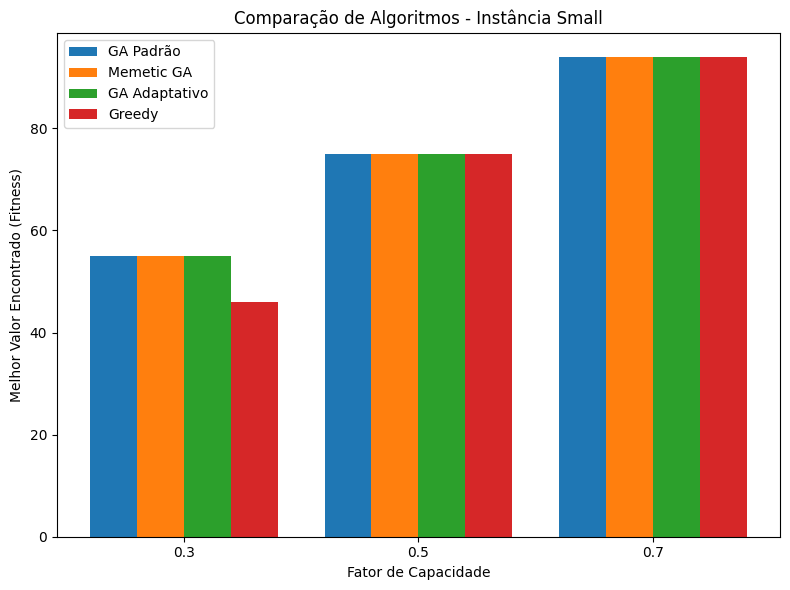

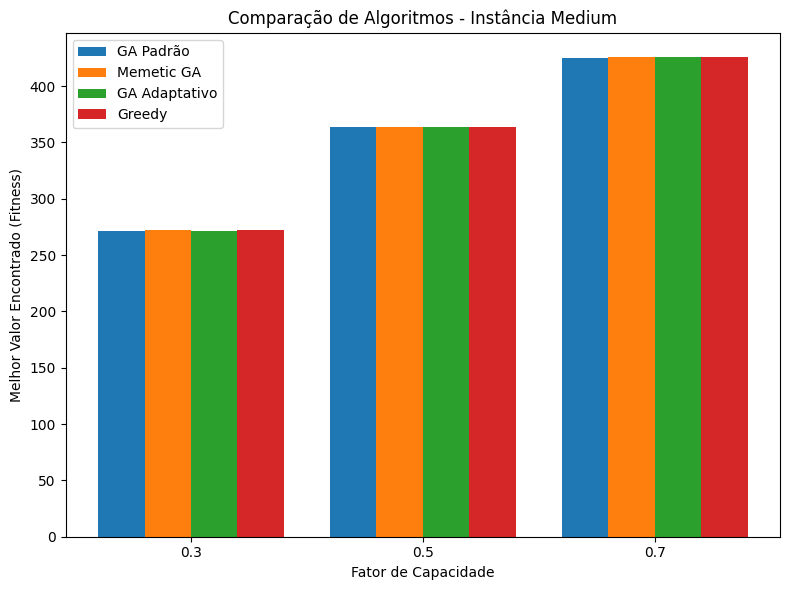

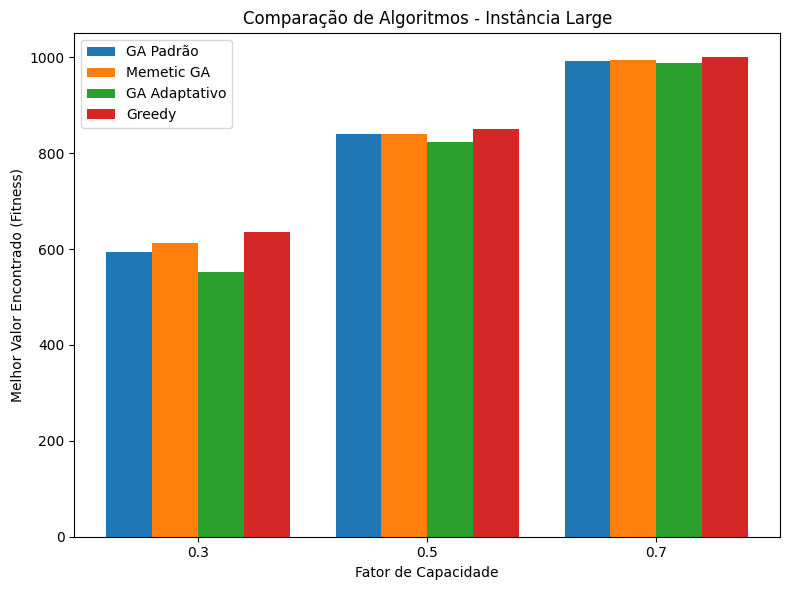

In [ ]:
plot_grouped_bar_charts(results, capacity_factors)

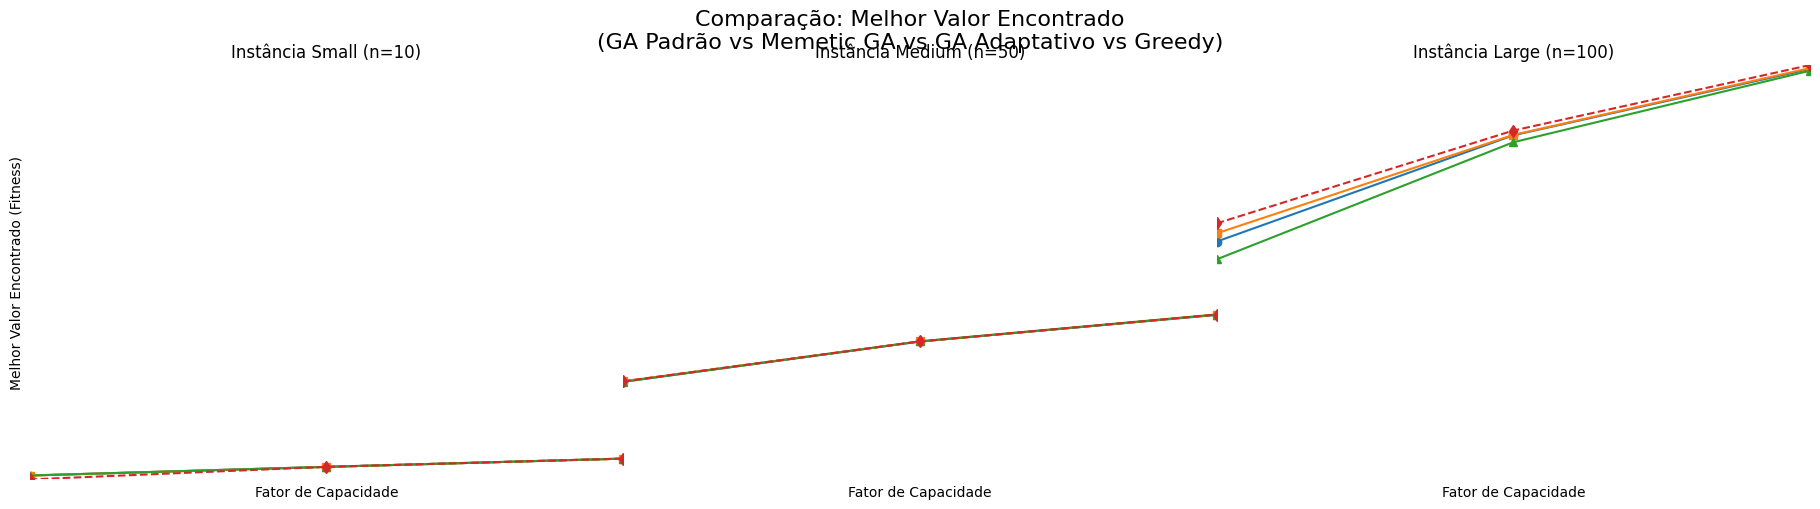

In [ ]:
plot_results(results, capacity_factors)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grouped_bar_charts1(results, capacity_factors):
    instance_types = list(results.keys())
    bar_width = 0.2  # Largura de cada barra

    for inst in instance_types:
        fig, ax = plt.subplots(figsize=(8, 6))

        # Posições das barras no eixo x
        x_pos = np.arange(len(capacity_factors))

        # Dados para cada algoritmo
        ga_bests = [results[inst][factor]["GA"][2] for factor in capacity_factors]
        mem_bests = [results[inst][factor]["Memetic"][2] for factor in capacity_factors]
        adapt_bests = [results[inst][factor]["Adaptive"][2] for factor in capacity_factors]
        greedy_vals = [results[inst][factor]["Greedy"] for factor in capacity_factors]

        # Criar as barras com cores diferenciadas
        bars1 = ax.bar(x_pos - 1.5*bar_width, ga_bests, bar_width, alpha=0.8, color='royalblue', label='GA Padrão')
        bars2 = ax.bar(x_pos - 0.5*bar_width, mem_bests, bar_width, alpha=0.8, color='seagreen', label='Memetic GA')
        bars3 = ax.bar(x_pos + 0.5*bar_width, adapt_bests, bar_width, alpha=0.8, color='darkorange', label='GA Adaptativo')
        bars4 = ax.bar(x_pos + 1.5*bar_width, greedy_vals, bar_width, alpha=0.8, color='crimson', label='Greedy')

        # Adicionar valores no topo das barras com rotação diagonal
        for bars in [bars1, bars2, bars3, bars4]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}',
                        ha='center', fontsize=10, rotation=45, fontweight='bold')

        # Configuração dos eixos
        ax.set_title(f"Comparação de Algoritmos - Instância {inst}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Fator de Capacidade", fontsize=12)
        ax.set_ylabel("Melhor Valor Encontrado (Fitness)", fontsize=12)
        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(factor) for factor in capacity_factors], fontsize=10, rotation=20)  # Rotacionar rótulos do eixo X
        ax.legend(fontsize=10)

        # Adicionar linhas de grade no eixo Y para melhor visualização
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()



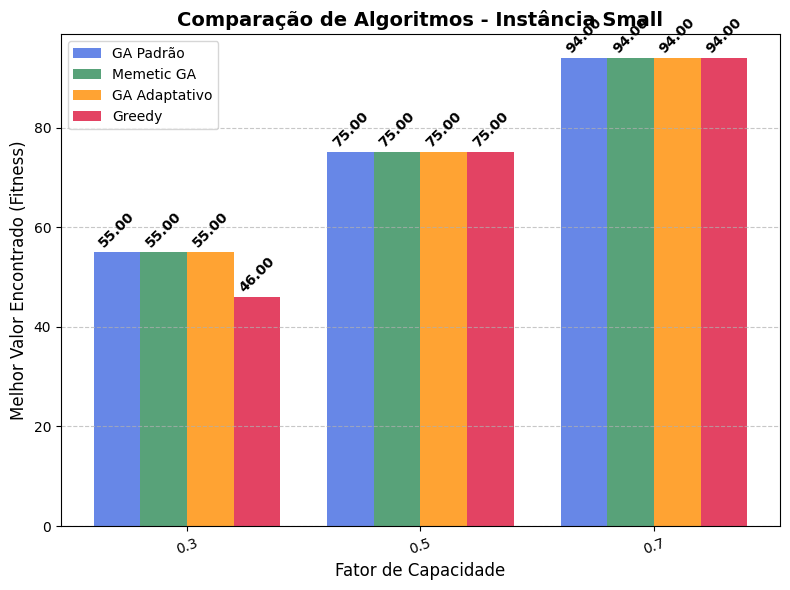

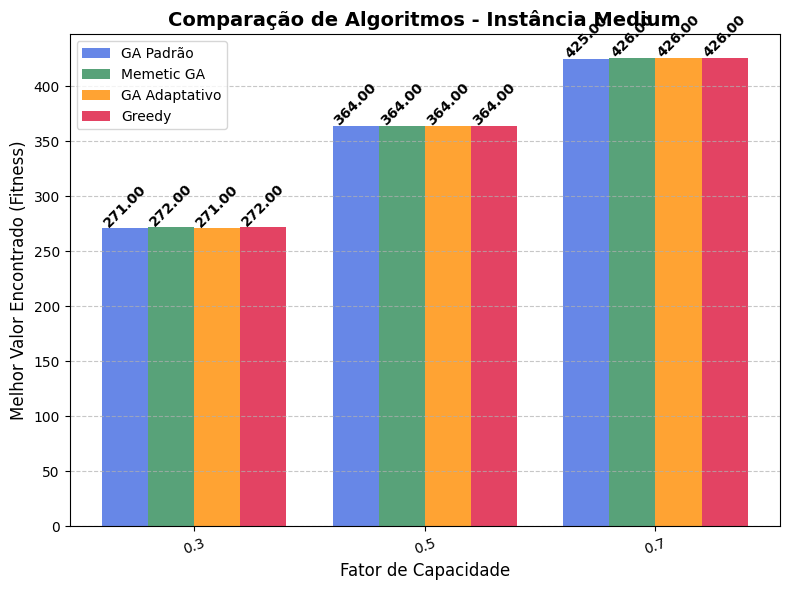

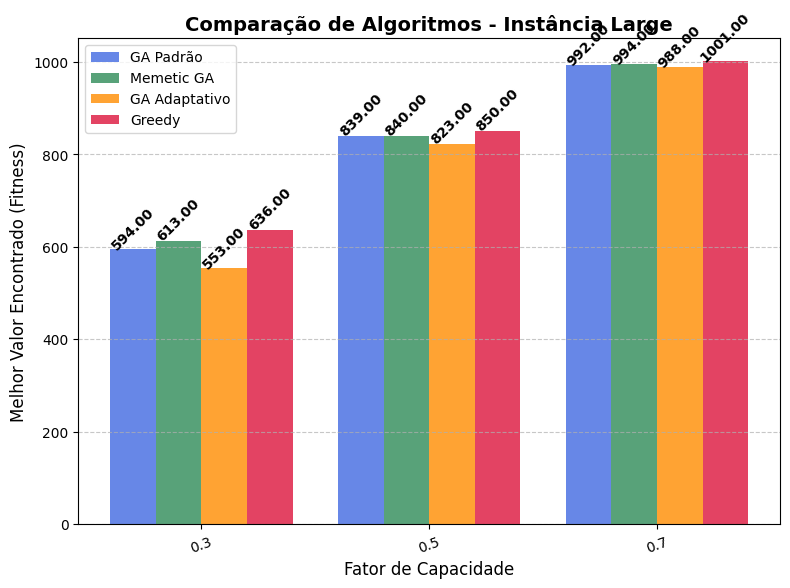

In [ ]:
plot_grouped_bar_charts1(results,capacity_factors)

#Comparação com material academico


In [ ]:
# Saida 1  small- Melhor valor  1024 - capacidade 879 - quantidade  20
# Saida 2  medium - Melhor valor  2968 - capacidade 940 - quantidade  51
# Saida 2  large - Melhor valor : 11514 -  capacidade 1000  quantidade - 100

In [ ]:
def read_input_file(filename):
    """
    Lê um arquivo no formato:
      n
      id_1 profit_1 weight_1
      id_2 profit_2 weight_2
      ...
      id_n profit_n weight_n
      capacity
    Retorna:
      - items: lista de tuplas (weight, profit) para compatibilidade com os métodos
      - capacity: capacidade da mochila
    """
    with open(filename, "r") as f:
        lines = f.read().splitlines()

    n = int(lines[0].strip())
    items = []
    for i in range(1, n + 1):
        parts = lines[i].split()
        # Cada linha possui: id, profit, weight. Usamos weight e profit.
        item_id, profit, weight = map(int, parts)
        items.append((weight, profit))
    capacity = int(lines[n + 1].strip())
    print(f"Items: {items}")
    print(f"Capacidade: {capacity}")
    return items, capacity

def run_experiments_from_file(input_file):
    # Lê os dados da instância a partir do arquivo .in
    items, capacity = read_input_file(input_file)
    print(f"Instância do arquivo: {len(items)} itens, Capacidade = {capacity}")

    results = {}
    results["FileInstance"] = {}
    results["FileInstance"]["File"] = {}

    num_runs = 10  # Número de execuções para métodos estocásticos

    # Executa experimentos para os métodos GA, Memetic e Adaptive
    for method in ["GA", "Memetic", "Adaptive"]:
        mean_val, std_val, best_overall = run_instance_experiment(method, items, capacity, num_runs=num_runs)
        results["FileInstance"]["File"][method] = (mean_val, std_val, best_overall)
        print(f"{method}: Média = {mean_val:.2f}, Desvio = {std_val:.2f}, Melhor = {best_overall:.2f}")

    # Para Greedy, que é determinístico
    _, greedy_val, _ = greedy_knapsack(items, capacity)
    results["FileInstance"]["File"]["Greedy"] = greedy_val
    print(f"Greedy: Valor = {greedy_val}")

    return results



In [ ]:

input_file = "arquivo2.in"
run_experiments_from_file(input_file)


Items: [(995, 100), (485, 482), (326, 257), (248, 286), (421, 517), (322, 404), (795, 713), (43, 45), (845, 924), (955, 873), (252, 160), (9, 1), (901, 838), (122, 40), (94, 58), (738, 676), (574, 627), (715, 766), (882, 862), (367, 405), (984, 923), (299, 379), (433, 461), (682, 612), (72, 133), (874, 813), (138, 97), (856, 908), (145, 165), (995, 996), (529, 623), (199, 220), (277, 298), (97, 157), (719, 723), (242, 144), (107, 48), (122, 129), (70, 148), (98, 35), (600, 644), (645, 632), (267, 272), (972, 1040), (895, 977), (213, 312), (748, 778), (487, 567), (923, 965), (29, 1), (674, 616), (540, 569), (554, 628), (467, 493), (46, 76), (710, 733), (553, 575), (191, 288), (724, 775), (730, 723), (988, 912), (90, 64), (340, 354), (549, 565), (196, 210), (865, 922), (678, 775), (570, 566), (936, 934), (722, 626), (651, 742), (123, 194), (431, 485), (508, 483), (585, 617), (853, 876), (642, 653), (992, 896), (725, 652), (286, 220), (812, 727), (859, 900), (663, 563), (88, 56), (179, 15

{'FileInstance': {'File': {'GA': (np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0)),
   'Memetic': (np.float64(0.0), np.float64(0.0), np.float64(0.0)),
   'Adaptive': (np.float64(0.0), np.float64(0.0), np.float64(0.0)),
   'Greedy': 1588}}}

In [ ]:

input_file = "arquivo2 copy.in"
run_experiments_from_file(input_file)


Items: [(100, 50), (80, 220), (82, 208), (85, 198), (70, 192), (72, 180), (70, 180), (66, 165), (50, 162), (55, 160), (25, 158), (50, 155), (55, 130), (40, 125), (48, 122), (50, 120), (32, 118), (22, 115), (60, 110), (30, 105), (32, 101), (40, 100), (38, 100), (35, 98), (32, 96), (25, 95), (28, 90), (30, 88), (22, 82), (25, 80), (30, 77), (45, 75), (30, 73), (60, 72), (50, 70), (20, 69), (65, 66), (20, 65), (25, 63), (30, 60), (10, 58), (20, 56), (25, 50), (15, 30), (10, 20), (10, 15), (10, 10), (4, 8), (4, 5), (2, 3), (1, 1)]
Capacidade: 940
Instância do arquivo: 51 itens, Capacidade = 940
GA: Média = 2921.10, Desvio = 13.95, Melhor = 2948.00
Memetic: Média = 2958.40, Desvio = 5.31, Melhor = 2968.00
Adaptive: Média = 2934.30, Desvio = 16.65, Melhor = 2954.00
Greedy: Valor = 2968


{'FileInstance': {'File': {'GA': (np.float64(2921.1),
    np.float64(13.953135848260061),
    np.float64(2948.0)),
   'Memetic': (np.float64(2958.4),
    np.float64(5.314132102234569),
    np.float64(2968.0)),
   'Adaptive': (np.float64(2934.3),
    np.float64(16.649624620393098),
    np.float64(2954.0)),
   'Greedy': 2968}}}

In [ ]:

input_file = "arquivo2.in"
run_experiments_from_file(input_file)


A saída de streaming foi truncada nas últimas 5000 linhas.
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29

{'FileInstance': {'File': {'GA': (np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0)),
   'Memetic': (np.float64(0.0), np.float64(0.0), np.float64(0.0)),
   'Adaptive': (np.float64(0.0), np.float64(0.0), np.float64(0.0)),
   'Greedy': 1588}}}